In [2]:
!pip install tensorflow keras

  Using cached Keras-2.4.3-py2.py3-none-any.whl (36 kB)


In [3]:
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from datetime import datetime, timedelta
import csv
import pandas as pd
import numpy
numpy.random.seed(7)
            

In [30]:
dataframe = read_csv('SuperStore.csv',  engine='python')
dataframe

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
3,6,CA-2014-115812,6/9/2014,6/14/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.8600,7,0.00,14.1694
4,11,CA-2014-115812,6/9/2014,6/14/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-TA-10001539,Furniture,Tables,Chromcraft Rectangular Conference Tables,1706.1840,9,0.20,85.3092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2116,9963,CA-2015-168088,3/19/2015,3/22/2015,First Class,CM-12655,Corinna Mitchell,Home Office,United States,Houston,...,77041,Central,FUR-BO-10004218,Furniture,Bookcases,Bush Heritage Pine Collection 5-Shelf Bookcase...,383.4656,4,0.32,-67.6704
2117,9965,CA-2016-146374,12/5/2016,12/10/2016,Second Class,HE-14800,Harold Engle,Corporate,United States,Newark,...,19711,East,FUR-FU-10002671,Furniture,Furnishings,Electrix 20W Halogen Replacement Bulb for Zoom...,13.4000,1,0.00,6.4320
2118,9981,US-2015-151435,9/6/2015,9/9/2015,Second Class,SW-20455,Shaun Weien,Consumer,United States,Lafayette,...,70506,South,FUR-TA-10001039,Furniture,Tables,KI Adjustable-Height Table,85.9800,1,0.00,22.3548
2119,9990,CA-2014-110422,1/21/2014,1/23/2014,Second Class,TB-21400,Tom Boeckenhauer,Consumer,United States,Miami,...,33180,South,FUR-FU-10001889,Furniture,Furnishings,Ultra Door Pull Handle,25.2480,3,0.20,4.1028


In [31]:
dataframe.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

In [32]:
dataframe['Order Date'].min(), dataframe['Order Date'].max()

('1/1/2017', '9/9/2017')

In [33]:
df2=dataframe[['Order Date','Sales']]

In [34]:
df2 = df2.groupby('Order Date')['Sales'].sum().reset_index()

In [35]:
df2.values

array([['1/1/2017', 975.49],
       ['1/10/2014', 51.94],
       ['1/10/2015', 1018.1039999999999],
       ...,
       ['9/9/2014', 864.024],
       ['9/9/2016', 15.008],
       ['9/9/2017', 482.56399999999996]], dtype=object)

In [36]:
df2['Order Date'] = pd.to_datetime(df2['Order Date'])
df2.set_index('Order Date', inplace=True)
df2.index

DatetimeIndex(['2017-01-01', '2014-01-10', '2015-01-10', '2016-01-10',
               '2014-01-11', '2016-01-11', '2017-01-12', '2014-01-13',
               '2015-01-13', '2017-01-13',
               ...
               '2014-09-07', '2015-09-07', '2017-09-07', '2014-09-08',
               '2015-09-08', '2016-09-08', '2017-09-08', '2014-09-09',
               '2016-09-09', '2017-09-09'],
              dtype='datetime64[ns]', name='Order Date', length=889, freq=None)

In [37]:
y = df2['Sales'].resample('MS').mean()

In [11]:
y.values

array([ 480.19423077,  367.9316    ,  857.29152941,  567.48835714,
        432.0491875 ,  695.05924211,  601.1695    ,  457.52165625,
        992.35336667,  769.0154375 ,  980.22148636, 1532.298325  ,
        978.32846667,  522.39566667,  781.2364375 ,  805.82296154,
        624.9967    ,  428.5655    ,  719.70631579,  602.4120125 ,
       1382.79068421,  632.98018421, 1286.70135417, 1049.35541818,
        508.18286667,  356.86827273,  609.57580952,  695.37315789,
        687.26522727,  816.91075   ,  768.73641176,  734.30778235,
       1135.95337083,  624.87247368, 1271.345152  , 1410.71980769,
        397.60213333,  528.1798    ,  544.67224   ,  453.297905  ,
        678.302328  ,  826.4602913 ,  562.52485714,  857.88188889,
       1209.50858333,  875.362728  , 1277.81775862, 1256.298672  ])

In [12]:
dataset = y.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset.reshape(-1,1))
dataset

array([[0.10491988],
       [0.00941214],
       [0.4257363 ],
       [0.17918554],
       [0.06396034],
       [0.2877168 ],
       [0.20783985],
       [0.0856311 ],
       [0.54064053],
       [0.35063523],
       [0.5303193 ],
       [1.        ],
       [0.5287088 ],
       [0.14082286],
       [0.36103225],
       [0.3819493 ],
       [0.22811091],
       [0.06099656],
       [0.30868536],
       [0.20889693],
       [0.872806  ],
       [0.23490286],
       [0.79105777],
       [0.58913517],
       [0.12873125],
       [0.        ],
       [0.21499157],
       [0.2879839 ],
       [0.28108597],
       [0.39138228],
       [0.35039783],
       [0.32110763],
       [0.66280854],
       [0.22800523],
       [0.7779934 ],
       [0.8965668 ],
       [0.03465444],
       [0.1457437 ],
       [0.15977469],
       [0.08203775],
       [0.2734608 ],
       [0.3995065 ],
       [0.17496282],
       [0.42623854],
       [0.72538584],
       [0.44111043],
       [0.7835    ],
       [0.765

In [13]:
#dataset=(dataset - dataset.min())/(dataset.max()-dataset.min())

In [41]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back)]
		dataX.append(a)
		dataY.append(dataset[i + look_back])
	return numpy.array(dataX), numpy.array(dataY)

In [42]:
y.shape

(48,)

In [44]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size

In [45]:
dataset[0:train_size]

array([[0.10491988],
       [0.00941214],
       [0.4257363 ],
       [0.17918554],
       [0.06396034],
       [0.2877168 ],
       [0.20783985],
       [0.0856311 ],
       [0.54064053],
       [0.35063523],
       [0.5303193 ],
       [1.        ],
       [0.5287088 ],
       [0.14082286],
       [0.36103225],
       [0.3819493 ],
       [0.22811091],
       [0.06099656],
       [0.30868536],
       [0.20889693],
       [0.872806  ],
       [0.23490286],
       [0.79105777],
       [0.58913517],
       [0.12873125],
       [0.        ],
       [0.21499157],
       [0.2879839 ],
       [0.28108597],
       [0.39138228],
       [0.35039783],
       [0.32110763]], dtype=float32)

In [46]:

train, test = dataset[0:train_size], dataset[train_size:len(dataset)]

In [47]:
train_size

32

In [48]:
test_size

16

In [49]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
trainX.shape
testX, testY = create_dataset(test, look_back)
testX.shape
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [50]:
trainX.shape


(30, 1, 1)

In [51]:
testX.shape


(14, 1, 1)

In [52]:
trainY.shape

(30, 1)

In [53]:
testY.shape

(14, 1)

In [54]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(32, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=400, batch_size=1, verbose=2)

Epoch 1/400
30/30 - 3s - loss: 0.1453
Epoch 2/400
30/30 - 0s - loss: 0.1087
Epoch 3/400
30/30 - 0s - loss: 0.0784
Epoch 4/400
30/30 - 0s - loss: 0.0659
Epoch 5/400
30/30 - 0s - loss: 0.0586
Epoch 6/400
30/30 - 0s - loss: 0.0567
Epoch 7/400
30/30 - 0s - loss: 0.0567
Epoch 8/400
30/30 - 0s - loss: 0.0566
Epoch 9/400
30/30 - 0s - loss: 0.0566
Epoch 10/400
30/30 - 0s - loss: 0.0564
Epoch 11/400
30/30 - 0s - loss: 0.0568
Epoch 12/400
30/30 - 0s - loss: 0.0566
Epoch 13/400
30/30 - 0s - loss: 0.0569
Epoch 14/400
30/30 - 0s - loss: 0.0564
Epoch 15/400
30/30 - 0s - loss: 0.0570
Epoch 16/400
30/30 - 0s - loss: 0.0576
Epoch 17/400
30/30 - 0s - loss: 0.0563
Epoch 18/400
30/30 - 0s - loss: 0.0566
Epoch 19/400
30/30 - 0s - loss: 0.0569
Epoch 20/400
30/30 - 0s - loss: 0.0563
Epoch 21/400
30/30 - 0s - loss: 0.0570
Epoch 22/400
30/30 - 0s - loss: 0.0568
Epoch 23/400
30/30 - 0s - loss: 0.0567
Epoch 24/400
30/30 - 0s - loss: 0.0564
Epoch 25/400
30/30 - 0s - loss: 0.0565
Epoch 26/400
30/30 - 0s - loss: 0.

Epoch 209/400
30/30 - 0s - loss: 0.0565
Epoch 210/400
30/30 - 0s - loss: 0.0566
Epoch 211/400
30/30 - 0s - loss: 0.0563
Epoch 212/400
30/30 - 0s - loss: 0.0564
Epoch 213/400
30/30 - 0s - loss: 0.0568
Epoch 214/400
30/30 - 0s - loss: 0.0573
Epoch 215/400
30/30 - 0s - loss: 0.0567
Epoch 216/400
30/30 - 0s - loss: 0.0563
Epoch 217/400
30/30 - 0s - loss: 0.0568
Epoch 218/400
30/30 - 0s - loss: 0.0567
Epoch 219/400
30/30 - 0s - loss: 0.0567
Epoch 220/400
30/30 - 0s - loss: 0.0566
Epoch 221/400
30/30 - 0s - loss: 0.0565
Epoch 222/400
30/30 - 0s - loss: 0.0566
Epoch 223/400
30/30 - 0s - loss: 0.0566
Epoch 224/400
30/30 - 0s - loss: 0.0569
Epoch 225/400
30/30 - 0s - loss: 0.0568
Epoch 226/400
30/30 - 0s - loss: 0.0568
Epoch 227/400
30/30 - 0s - loss: 0.0562
Epoch 228/400
30/30 - 0s - loss: 0.0570
Epoch 229/400
30/30 - 0s - loss: 0.0569
Epoch 230/400
30/30 - 0s - loss: 0.0564
Epoch 231/400
30/30 - 0s - loss: 0.0568
Epoch 232/400
30/30 - 0s - loss: 0.0565
Epoch 233/400
30/30 - 0s - loss: 0.0565


In [55]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict[:]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict[:]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 278.24 RMSE
Test Score: 329.23 RMSE


In [27]:
trainPredict

array([[705.1591 ],
       [684.4043 ],
       [776.42896],
       [721.45917],
       [696.2284 ],
       [745.5075 ],
       [727.78326],
       [700.94806],
       [802.4132 ],
       [759.56024],
       [800.0715 ],
       [907.675  ],
       [799.7062 ],
       [713.0225 ],
       [761.8895 ],
       [766.58185],
       [732.2683 ],
       [695.58386],
       [750.1822 ],
       [728.0169 ],
       [878.384  ],
       [733.7731 ],
       [859.60034],
       [813.435  ],
       [710.3706 ],
       [682.37244],
       [729.3645 ],
       [745.567  ],
       [744.03107],
       [768.7004 ]], dtype=float32)

In [28]:
trainY

array([[ 367.93158],
       [ 857.2915 ],
       [ 567.48834],
       [ 432.0492 ],
       [ 695.05927],
       [ 601.1695 ],
       [ 457.52167],
       [ 992.3534 ],
       [ 769.01544],
       [ 980.2215 ],
       [1532.2982 ],
       [ 978.3285 ],
       [ 522.3957 ],
       [ 781.23645],
       [ 805.823  ],
       [ 624.9967 ],
       [ 428.56546],
       [ 719.70636],
       [ 602.412  ],
       [1382.7906 ],
       [ 632.98016],
       [1286.7013 ],
       [1049.3555 ],
       [ 508.18286],
       [ 356.8683 ],
       [ 609.5758 ],
       [ 695.3732 ],
       [ 687.2652 ],
       [ 816.91077],
       [ 768.7364 ]], dtype=float32)

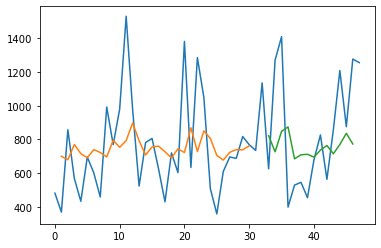

In [56]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()